#Welcome to the MPDL project

First We are going to fetch data from Springer

In [8]:
%pip install springernature-api-client

In [9]:
import os
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("SPRINGER_API_KEY")


In [10]:
import springernature_api_client.metadata as metadata
import springernature_api_client.openaccess as openaccess
import springernature_api_client.meta as meta
import springernature_api_client.tdm as tdm



# Initialize different API clients
openaccess_client = openaccess.OpenAccessAPI(api_key=API_KEY)
#meta_client = meta.MetaAPI(api_key=API_KEY)
#metadata_client = metadata.MetadataAPI(api_key=API_KEY)
#tdm_client = tdm.TdmAPI(api_key=API_KEY)


we use climate change data in our example

In [11]:
response = openaccess_client.search(q="climate change", p=20, s=1, fetch_all=False, is_premium=False)


2025-03-23 10:38:57,279 - INFO - Making request to: https://api.springernature.com/openaccess/json with params: {'q': 'climate change', 'p': 20, 's': 1, 'api_key': '46861e50f23a7cc918b1b44c39fa6f13'}


Fetching openaccess: query='climate change', page=20, start=1


In [12]:
import pandas as pd

# Convert response to DataFrame
if "records" in response:
    df = pd.DataFrame(response["records"])
    print(df.head())

    # Save to a JSON file
    df.to_json("springer_data.json", orient="records", indent=4)

    # Save to a CSV file
    df.to_csv("springer_data.csv", index=False)

    print("Data saved successfully!")


  contentType                      identifier language  \
0     Article  doi:10.1007/s10750-024-05641-z       en   
1     Article  doi:10.1007/s10750-024-05505-6       en   
2     Article  doi:10.1007/s10750-024-05580-9       en   
3     Article  doi:10.1007/s10750-024-05533-2       en   
4     Article  doi:10.1007/s10750-024-05658-4       en   

                                                 url  \
0  [{'format': '', 'platform': '', 'value': 'http...   
1  [{'format': '', 'platform': '', 'value': 'http...   
2  [{'format': '', 'platform': '', 'value': 'http...   
3  [{'format': '', 'platform': '', 'value': 'http...   
4  [{'format': '', 'platform': '', 'value': 'http...   

                                               title  \
0  Multi-method distribution modelling of an inva...   
1  Assessing the impact of the invasive ctenophor...   
2  Differential survival of Ilyanassa obsoleta to...   
3  Movements and habitat use of native and invasi...   
4  Stable isotope analysis reveals

next we perform data cleaning

In [13]:
import json
import pandas as pd

# Load the previously fetched Springer data
with open("springer_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Ensure data format
if isinstance(data, dict) and "records" in data:
    records = data["records"]  # Extract records list
elif isinstance(data, list):
    records = data  # Data is already a list
else:
    raise ValueError("Unexpected data format: Expected a list or dictionary with 'records' key.")

# Convert to DataFrame
df = pd.DataFrame(records)

# Handle missing keys safely
df["url"] = df["url"].apply(lambda x: x[0]["value"] if isinstance(x, list) and x else None)
df["creators"] = df["creators"].apply(lambda x: ", ".join([c.get("creator", "") for c in x]) if isinstance(x, list) else None)

# 🛠 **Fix for subjects column**
def extract_subjects(x):
    if isinstance(x, list):  # Ensure x is a list
        return ", ".join([s.get("term", "") for s in x if isinstance(s, dict)])  # Extract terms safely
    elif isinstance(x, str):  # If it's a string, return it directly
        return x
    else:
        return None  # Return None for unexpected formats

df["subjects"] = df["subjects"].apply(extract_subjects)

# Select relevant columns (handle missing columns safely)
columns_to_keep = ["contentType", "identifier", "language", "url", "title", "creators", "publicationName", "subjects"]
df_cleaned = df[[col for col in columns_to_keep if col in df.columns]]

# Save cleaned data
df_cleaned.to_json("springer_data_clean.json", orient="records", indent=4)
df_cleaned.to_csv("springer_data_clean.csv", index=False)

print("✅ Climate Change data successfully cleaned and saved!")
print(df_cleaned.head())




✅ Climate Change data successfully cleaned and saved!
  contentType                      identifier language  \
0     Article  doi:10.1007/s10750-024-05641-z       en   
1     Article  doi:10.1007/s10750-024-05505-6       en   
2     Article  doi:10.1007/s10750-024-05580-9       en   
3     Article  doi:10.1007/s10750-024-05533-2       en   
4     Article  doi:10.1007/s10750-024-05658-4       en   

                                            url  \
0  http://dx.doi.org/10.1007/s10750-024-05641-z   
1  http://dx.doi.org/10.1007/s10750-024-05505-6   
2  http://dx.doi.org/10.1007/s10750-024-05580-9   
3  http://dx.doi.org/10.1007/s10750-024-05533-2   
4  http://dx.doi.org/10.1007/s10750-024-05658-4   

                                               title  \
0  Multi-method distribution modelling of an inva...   
1  Assessing the impact of the invasive ctenophor...   
2  Differential survival of Ilyanassa obsoleta to...   
3  Movements and habitat use of native and invasi...   
4  Stable 

I have already installed PostgreSQL17 and pgAdmin on my windows machine

start the database server (if not already). default is port 5432

In [14]:
%pip install psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


In [15]:
import psycopg2

Do a quick check

In [16]:
import psycopg2

conn = psycopg2.connect(
    dbname="research_metadata",
    user="postgres",
    password="password123",
    host="localhost",
    port="5432"  # Use the port you found in pgAdmin
)

print("✅ Connected to PostgreSQL successfully!")
conn.close()


✅ Connected to PostgreSQL successfully!


In [17]:
import psycopg2
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()
DB_PASSWORD = os.getenv("DB_PASSWORD")

# 🛠 PostgreSQL connection details
DB_NAME = "research_metadata"
DB_USER = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"  # Change if your PostgreSQL is using a different port

# Load cleaned CSV data
df = pd.read_csv("springer_data_clean.csv")

try:
    # 🟢 Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST, port=DB_PORT
    )
    cur = conn.cursor()
    print("✅ Connected to PostgreSQL!")

    # 🛠 Insert data into the database
    for _, row in df.iterrows():
        cur.execute(
            """
            INSERT INTO research_articles (content_type, identifier, language, url, title, creators, publication_name, subjects)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (identifier) DO NOTHING;
            """,
            (
                row["contentType"],
                row["identifier"],
                row["language"],
                row["url"],
                row["title"],
                row["creators"],
                row["publicationName"],
                row["subjects"],
            ),
        )

    # Commit the changes
    conn.commit()
    print("✅ Data successfully inserted into PostgreSQL!")

except Exception as e:
    print("❌ Database error:", e)

finally:
    cur.close()
    conn.close()
    print("🔌 PostgreSQL connection closed.")


✅ Connected to PostgreSQL!
✅ Data successfully inserted into PostgreSQL!
🔌 PostgreSQL connection closed.


Data exploration with SQL. Run the following queries in pgAdmin

Count the total number of articles

```

SELECT COUNT(*) FROM research_articles;
```

list the most frequent journals

```
SELECT publication_name, COUNT(*) AS num_articles
FROM research_articles
GROUP BY publication_name
ORDER BY num_articles DESC
LIMIT 10;
```

identify the most published authors

```
SELECT creators, COUNT(*) AS num_articles
FROM research_articles
GROUP BY creators
ORDER BY num_articles DESC
LIMIT 10;
```


Data exploration with Pandas

Total Articles: 20


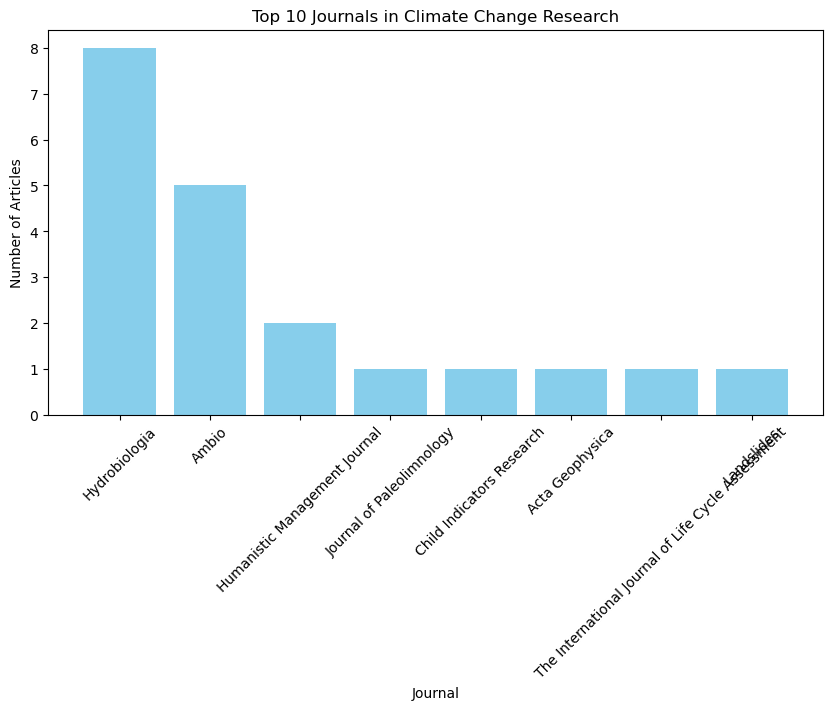

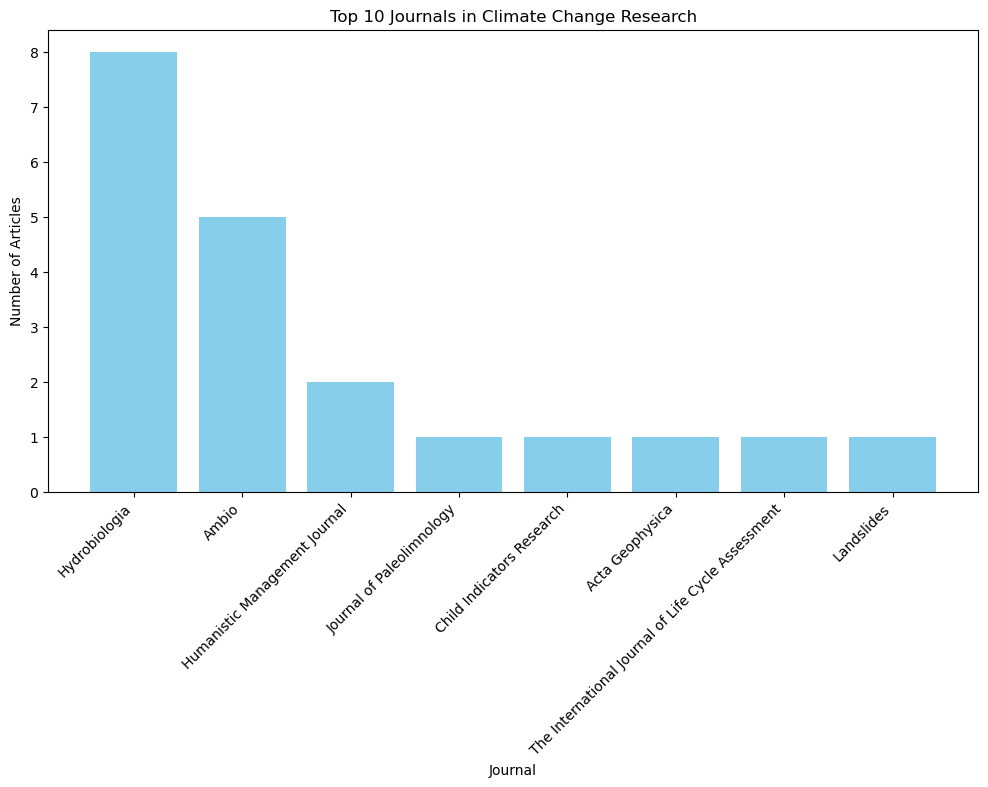

In [18]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables
load_dotenv()
DB_PASSWORD = os.getenv("DB_PASSWORD")

# PostgreSQL connection details
DB_NAME = "research_metadata"
DB_USER = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"

# ✅ Use SQLAlchemy to manage the database connection
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Function to Run SQL Query and Return Pandas DataFrame
def run_query(query):
    with engine.connect() as conn:
        df = pd.read_sql_query(query, conn)
    return df

# 🟢 Run Queries and Analyze Data

# 1️⃣ Total Number of Articles
total_articles = run_query("SELECT COUNT(*) FROM research_articles;")
print("Total Articles:", total_articles.iloc[0, 0])

# 2️⃣ Top 10 Journals by Publication Count
top_journals = run_query("""
    SELECT publication_name, COUNT(*) AS num_articles
    FROM research_articles
    GROUP BY publication_name
    ORDER BY num_articles DESC
    LIMIT 10;
""")

plt.figure(figsize=(10,5))
plt.bar(top_journals["publication_name"], top_journals["num_articles"], color="skyblue")
plt.xlabel("Journal")
plt.ylabel("Number of Articles")
plt.title("Top 10 Journals in Climate Change Research")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Top 10 Authors by Publication Count
top_authors = run_query("""
    SELECT creators, COUNT(*) AS num_articles
    FROM research_articles
    GROUP BY creators
    ORDER BY num_articles DESC
    LIMIT 10;
""")



plt.figure(figsize=(12, 6))  # Increase figure size for better readability
plt.bar(top_journals["publication_name"], top_journals["num_articles"], color="skyblue")

plt.xlabel("Journal")
plt.ylabel("Number of Articles")
plt.title("Top 10 Journals in Climate Change Research")

# ✅ Ensure all journal names are displayed properly
plt.xticks(np.arange(len(top_journals)), top_journals["publication_name"], rotation=45, ha="right")

plt.show()




In [19]:
%pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.
